In [1]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image preprocessing

We have 6 folders of .jpg image files, of varying sizes.  To use these for a machine learning project, we need to ensure
1. Consistent size
2. TFrecord format

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image # image processing
import cv2 # also image processing, maybe don't use this for tfrecord processing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
from io import BytesIO

PNG
RGB
(512, 512)
None


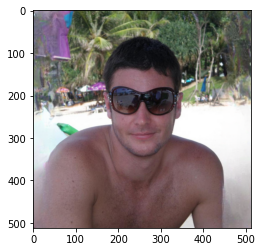

In [5]:
image = Image.open('../input/ganfolk/GANfolk_open_images/open_images/test_0044df245dafe994.png')
# The file format of the source file.
print(image.format) # Output: JPEG

# The pixel format used by the image. Typical values are "1", "L", "RGB", or "CMYK."
print(image.mode) # Output: RGB

# Image size, in pixels. The size is given as a 2-tuple (width, height).
print(image.size) # Output: (1920, 1280)

# Colour palette table, if any.
print(image.palette) # Output: None
#image.show() #show() method doesn't work in Kaggle
imgplot = plt.imshow(image)

Now to resize.  2 ways of doing this: either use the resize function, which will not preserve the aspect ratio...

In [6]:
new_image = image.resize((512, 512))

print(image.size) # Output: (994, 994)
print(new_image.size) # Output: (512, 512)

(512, 512)
(512, 512)


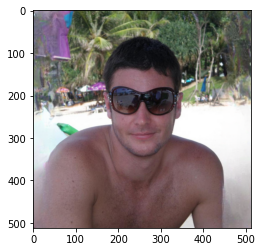

In [7]:
imgplot = plt.imshow(new_image)

2022-10-27 08:57:37.984945: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


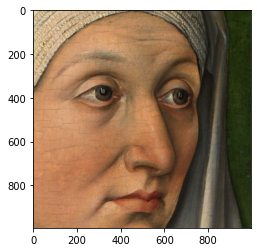

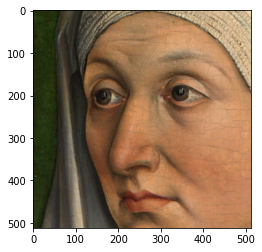

In [8]:
#
initimg = tf.io.decode_jpeg(tf.io.read_file('../input/portraits-in-art/faces_6class - 10/face_NorthernRenaiss/albrecht-d-rer-072.jpg'))
plt.figure()
plt.imshow(initimg)

testimg = tf.image.convert_image_dtype(initimg, tf.float32)
testimg = tf.image.resize_with_pad(testimg, target_height=512, target_width=512)
testimg = tf.image.flip_left_right(testimg)

plt.figure()
plt.imshow(testimg)

In [9]:
print(type(testimg))
print(isinstance(testimg, type(tf.constant(0))))

<class 'tensorflow.python.framework.ops.EagerTensor'>
True


# Creating TFrecords

In [10]:
# Get filespaths to image folders
PATH_NORTH = '../input/portraits-in-art/faces_6class - 10/face_NorthernRenaiss/'
PATH_UKIYO = '../input/portraits-in-art/faces_6class - 10/face_Ukiyo/'
PATH_HIGH = '../input/portraits-in-art/faces_6class - 10/face_highRenaiss/'
PATH_IMPRESS = '../input/portraits-in-art/faces_6class - 10/face_impress/'
PATH_POSTIMPRESS = '../input/portraits-in-art/faces_6class - 10/face_postimpress/'
PATH_ROCOCO = '../input/portraits-in-art/faces_6class - 10/face_rococo/'

PATH_PHOTO = '../input/ganfolk/GANfolk_open_images/open_images/'

IMGS_NORTH = os.listdir(PATH_NORTH)
IMGS_UKIYO = os.listdir(PATH_UKIYO)

IMGS_PHOTO = os.listdir(PATH_PHOTO)

print('There are %i Northern Renaissence images and %i Photo images'%(len(IMGS_NORTH),len(IMGS_PHOTO)))

#Create PATHs to our destination folders
TFREC_NORTH = './north_tfrec/'
TFREC_UKIYO = './ukiyo_tfrec/'
TFREC_HIRENAIS = './hirenais_tfrec/'
TFREC_IMPRESS = './impress_tfrec/'
TFREC_POSTIMPRESS = './postimpress_tfrec/'
TFREC_ROCOCO = './rococo_tfrec/'

TFREC_PHOTO = './photo_tfrec/'

#Create new folders
if not (os.path.exists(TFREC_NORTH)):
    os.mkdir(TFREC_NORTH)

if not(os.path.exists(TFREC_UKIYO)):
    os.mkdir(TFREC_UKIYO)

if not(os.path.exists(TFREC_HIRENAIS)):
    os.mkdir(TFREC_HIRENAIS)   

if not(os.path.exists(TFREC_IMPRESS)):
    os.mkdir(TFREC_IMPRESS)  

if not(os.path.exists(TFREC_POSTIMPRESS)):
    os.mkdir(TFREC_POSTIMPRESS) 

if not(os.path.exists(TFREC_ROCOCO)):
    os.mkdir(TFREC_ROCOCO) 

if not(os.path.exists(TFREC_PHOTO)):
    os.mkdir(TFREC_PHOTO) 

There are 140 Northern Renaissence images and 2700 Photo images


In [11]:
#  Utility functions - probably don't need all of these
#new Image encoder
def _image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
def serialize_example(feature0, feature1):
  feature = {
      'image_name': _bytes_feature(feature0),
      'image': _bytes_feature(feature1)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [13]:
IMAGE_SIZE = [512, 512]

# Create a helper function to write TFrecords for each folder
def create_tfrecords_from_folder(source_path, destination_path, title = '', size=10):
    
    IMGS = os.listdir(source_path)
    #If they don't already exist, create new folders
    if not (os.path.exists(destination_path)):
        os.mkdir(destination_path)
    
    SIZE = 10
    CT = len(IMGS)//SIZE + int(len(IMGS)%SIZE!=0)
    for j in range(CT):
        print(); print('Writing TFRecord %i of %i...'%(j,CT))
        CT2 = min(SIZE,len(IMGS)-j*SIZE)
        with tf.io.TFRecordWriter(destination_path + title + '%.2i-%i.tfrec'%(j,CT2)) as writer:
            for k in range(CT2):
                pil_image = Image.open(source_path+IMGS[SIZE*j+k])
                pil_image = pil_image.resize((512, 512))
                buf= BytesIO()
                pil_image.save(buf, format= 'JPEG') # encode to jpeg in memory
                img = buf.getvalue()
                name = IMGS[SIZE*j+k].split('.')[0]
                example = serialize_example(
                    feature1 = img, 
                    feature0 = str.encode(name))
                writer.write(example)
                if k%100==0: print(k,', ',end='')

In [14]:
#test our function
create_tfrecords_from_folder(source_path = PATH_HIGH, destination_path = TFREC_HIRENAIS, title = 'hirenais', size = 12)


Writing TFRecord 0 of 16...
0 , 
Writing TFRecord 1 of 16...
0 , 
Writing TFRecord 2 of 16...
0 , 
Writing TFRecord 3 of 16...
0 , 
Writing TFRecord 4 of 16...
0 , 
Writing TFRecord 5 of 16...
0 , 
Writing TFRecord 6 of 16...
0 , 
Writing TFRecord 7 of 16...
0 , 
Writing TFRecord 8 of 16...
0 , 
Writing TFRecord 9 of 16...
0 , 
Writing TFRecord 10 of 16...
0 , 
Writing TFRecord 11 of 16...
0 , 
Writing TFRecord 12 of 16...
0 , 
Writing TFRecord 13 of 16...
0 , 
Writing TFRecord 14 of 16...
0 , 
Writing TFRecord 15 of 16...
0 , 

In [15]:
#All works, so we are free to create our Tfrecords
create_tfrecords_from_folder(source_path = PATH_NORTH, destination_path = TFREC_NORTH, title='north', size = 10)
create_tfrecords_from_folder(source_path = PATH_UKIYO, destination_path = TFREC_UKIYO, title='ukiyo', size = 10)
create_tfrecords_from_folder(source_path = PATH_IMPRESS, destination_path = TFREC_IMPRESS, title='impress', size = 10)
create_tfrecords_from_folder(source_path = PATH_POSTIMPRESS, destination_path = TFREC_POSTIMPRESS, title='postimpress', size = 10)
create_tfrecords_from_folder(source_path = PATH_ROCOCO, destination_path = TFREC_ROCOCO, title='rococo', size = 10)


Writing TFRecord 0 of 14...
0 , 
Writing TFRecord 1 of 14...
0 , 
Writing TFRecord 2 of 14...
0 , 
Writing TFRecord 3 of 14...
0 , 
Writing TFRecord 4 of 14...
0 , 
Writing TFRecord 5 of 14...
0 , 
Writing TFRecord 6 of 14...
0 , 
Writing TFRecord 7 of 14...
0 , 
Writing TFRecord 8 of 14...
0 , 
Writing TFRecord 9 of 14...
0 , 
Writing TFRecord 10 of 14...
0 , 
Writing TFRecord 11 of 14...
0 , 
Writing TFRecord 12 of 14...
0 , 
Writing TFRecord 13 of 14...
0 , 
Writing TFRecord 0 of 12...
0 , 
Writing TFRecord 1 of 12...
0 , 
Writing TFRecord 2 of 12...
0 , 
Writing TFRecord 3 of 12...
0 , 
Writing TFRecord 4 of 12...
0 , 
Writing TFRecord 5 of 12...
0 , 
Writing TFRecord 6 of 12...
0 , 
Writing TFRecord 7 of 12...
0 , 
Writing TFRecord 8 of 12...
0 , 
Writing TFRecord 9 of 12...
0 , 
Writing TFRecord 10 of 12...
0 , 
Writing TFRecord 11 of 12...
0 , 
Writing TFRecord 0 of 20...
0 , 
Writing TFRecord 1 of 20...
0 , 
Writing TFRecord 2 of 20...
0 , 
Writing TFRecord 3 of 20...
0 , 
Wri

In [16]:
#Create a larger set for our photo data
create_tfrecords_from_folder(source_path = PATH_PHOTO, destination_path = TFREC_PHOTO, title='photo', size = 100)


Writing TFRecord 0 of 270...
0 , 
Writing TFRecord 1 of 270...
0 , 
Writing TFRecord 2 of 270...
0 , 
Writing TFRecord 3 of 270...
0 , 
Writing TFRecord 4 of 270...
0 , 
Writing TFRecord 5 of 270...
0 , 
Writing TFRecord 6 of 270...
0 , 
Writing TFRecord 7 of 270...
0 , 
Writing TFRecord 8 of 270...
0 , 
Writing TFRecord 9 of 270...
0 , 
Writing TFRecord 10 of 270...
0 , 
Writing TFRecord 11 of 270...
0 , 
Writing TFRecord 12 of 270...
0 , 
Writing TFRecord 13 of 270...
0 , 
Writing TFRecord 14 of 270...
0 , 
Writing TFRecord 15 of 270...
0 , 
Writing TFRecord 16 of 270...
0 , 
Writing TFRecord 17 of 270...
0 , 
Writing TFRecord 18 of 270...
0 , 
Writing TFRecord 19 of 270...
0 , 
Writing TFRecord 20 of 270...
0 , 
Writing TFRecord 21 of 270...
0 , 
Writing TFRecord 22 of 270...
0 , 
Writing TFRecord 23 of 270...
0 , 
Writing TFRecord 24 of 270...
0 , 
Writing TFRecord 25 of 270...
0 , 
Writing TFRecord 26 of 270...
0 , 
Writing TFRecord 27 of 270...
0 , 
Writing TFRecord 28 of 270...